In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_parquet("../data/raw/puc_vendas.parquet")
df.head()

,COD_CUPOM,COD_CLIENTE,CLIENTE_FISICO_JURIDICO,SEXO_CLIENTE,DTNASCIMENTO_CLIENTE,COD_SKU,SKU,CATEGORIA_SKU,SUBCATEGORIA_SKU,COD_LOJA,UF_CIDADE,COD_CIDADE,NOME_CIDADE,DATA_CUPOM,UNIDADES,IDENTIFICADOR_PROMOCIONAL,PRECO_REGULAR,TOTAL_DESCONTO,TOTAL_BRUTO,TOTAL_LIQUIDO
0,782344,55750557.0,Pessoa Física,F,1980-11-18,10085918,VONAU FLASH 4MG 10CP,MEDICAMENTOS,REFERENCIA,764,RS,80400,PORTO ALEGRE,2024-04-11 17:13:25,1.0,NaN,47.03,12.70,47.03,34.33
1,759507,55750557.0,Pessoa Física,F,1980-11-18,10106687,APTANUTRI PREMIUM 3,NUTRICAO,NUTRICAO LEITES,764,RS,80400,PORTO ALEGRE,2024-02-19 15:47:17,1.0,NaN,73.99,14.80,73.99,59.19
2,742082,55750557.0,Pessoa Física,F,1980-11-18,10037705,TORRADA ISABELA 142G TRADICIONAL,CONVENIENCIA,CONVENIENCIA PERECIVEIS,764,RS,80400,PORTO ALEGRE,2024-01-05 19:48:52,1.0,NaN,5.99,0.00,5.99,5.99
3,747733,55750557.0,Pessoa Física,F,1980-11-18,10004419,OZEMPIC 1MG 4AGULHAS NOVOFINE,MEDICAMENTOS,PBM ESPECIAL,764,RS,80400,PORTO ALEGRE,2024-01-20 14:41:56,1.0,NaN,1220.52,254.37,1220.52,966.15
4,748216,55750557.0,Pessoa Física,F,1980-11-18,10030435,NOVALGINA 1G 20CP OPELLA,MEDICAMENTOS,REFERENCIA ONEROSOS,764,RS,80400,PORTO ALEGRE,2024-01-22 16:48:36,1.0,100271131.0,41.51,5.52,41.51,35.99


In [3]:
products = df.groupby(["COD_SKU", "SKU", "CATEGORIA_SKU", "SUBCATEGORIA_SKU"])["PRECO_REGULAR"].mean().reset_index()
products["PRECO_REGULAR"] = products["PRECO_REGULAR"].round(2)
products = products.rename(
    columns={
        "COD_SKU": "product_id",
        "SKU": "product_name",
        "CATEGORIA_SKU": "category",
        "SUBCATEGORIA_SKU": "subcategory",
        "PRECO_REGULAR": "price"
    }
)
products.head()

,product_id,product_name,category,subcategory,price
0,7,SERVICO EM DOMICILIO,DIVERSOS,SERVICOS TELE ENTREGA,5.00
1,10,MANIPULADOS,MANIPULADOS,MANIPULADOS MEDICAMENTOS,0.01
2,11,SERVICO DE APLICACAO DE INJETAVEIS,SERVIÇOS,SERVICOS FARMACEUTICOS,5.00
3,12,SERVICO DE GESTO VACINAL GRIPE CONVENIOS,SERVIÇOS,SERVICOS FARMACEUTICOS,7.98
4,13,SERVICO DE VERIFICACAO DE GLICEMIA CAPIL,SERVIÇOS,SERVICOS FARMACEUTICOS,3.00


In [4]:
print(f"Number of products: {products.shape[0]}")
print(f"Duplicated rows: {products.duplicated().sum()}")
print(f"Duplicated product_ids: {products['product_id'].duplicated().sum()}")
print(f"Duplicated products: {products[["product_name", "category", "subcategory"]].duplicated().sum()}")

Number of products: 20658
Duplicated rows: 0
Duplicated product_ids: 0
Duplicated products: 2405


## Dropping products with product_name, category and subcategory duplicated

In [5]:
products.drop_duplicates(subset=["product_name", "category", "subcategory"], keep="first", inplace=True)
print(f"New number of products: {products.shape[0]}")

New number of products: 18253


In [6]:
print(f"Number of unique categories: {products['category'].nunique()}")
print(f"Number of unique subcategories: {products['subcategory'].nunique()}")

Number of unique categories: 9
Number of unique subcategories: 80


In [7]:
products.category.value_counts()

category
MEDICAMENTOS        7815
PERFUMARIA          6287
CONVENIENCIA        2964
DERMO-COSMETICOS     968
NUTRICAO             189
SERVIÇOS              25
DIVERSOS               3
MANIPULADOS            1
IMOBILIZADO            1
Name: count, dtype: int64

## Dropping Servicos, Diversos, Manipulados and Imbolizado categories

In [8]:
products = products[~products["category"].isin(["SERVIÇOS", "DIVERSOS", "MANIPULADOS", "IMOBILIZADO"])]
products.category.value_counts()

category
MEDICAMENTOS        7815
PERFUMARIA          6287
CONVENIENCIA        2964
DERMO-COSMETICOS     968
NUTRICAO             189
Name: count, dtype: int64

In [9]:
print(f"New number of unique categories: {products['category'].nunique()}")
print(f"New number of unique subcategories: {products['subcategory'].nunique()}")

New number of unique categories: 5
New number of unique subcategories: 75


In [10]:
products.subcategory.value_counts()

subcategory
PERFUMARIA                                  5715
CONVENIENCIA BAZAR                          1634
REFERENCIA ONEROSOS                         1203
CONVENIENCIA PERECIVEIS                     1107
DERMO-COSMETICOS                             933
REFERENCIA                                   925
LIBERADOS                                    529
REFERENCIA CONTROLADO                        518
SIMILAR                                      419
REFERENCIA LIBERADO                          411
GENERICOS                                    394
HOSPITALARES                                 325
PBMS                                         310
REFERENCIA SUPER ONEROSOS                    304
GENERICOS ONEROSOS                           257
REFERENCIA LIBERADO SUPER ONEROSOS           211
REFERENCIA ONEROSO CONTROLADO                204
ANTIBIOTICO CONT. REFERENCIA                 170
GENERICO CONTROLADO                          166
FRALDAS                                      166
PERFUMAR

## Dropping subcategories with less than 11 products

In [11]:
# get subcategories with less than 10 appearances
under_11_subcategories = products["subcategory"].value_counts()
under_11_subcategories = under_11_subcategories[under_11_subcategories < 11]
under_11_subcategories = list(under_11_subcategories.to_frame().reset_index().subcategory.values)
under_11_subcategories

['TESTE COVID19',
 'DERMO-COSMETICOS ESPECIAL',
 'FITOTERAPICOS',
 'PBMS COMBO CONTROLADOS',
 'ANTIBIOTICO CONT. SIMILAR',
 'VACINA GRIPE',
 'SIMILAR CONTROLADO',
 'GENERICO CONTROLADO SUPER ONEROSO',
 'ANTIBIOTICO CONT. REFER AV',
 'REFERENCIA - GRUPO 2 CB',
 'KIT SOLIDARIEDADE',
 'MEDICAMENTOS DERMO COSMETICOS']

In [12]:
products = products[~products["subcategory"].isin(under_11_subcategories)]
print(f"Number of products: {products.shape[0]}")
print(f"New number of unique categories: {products['category'].nunique()}")
print(f"New number of unique subcategories: {products['subcategory'].nunique()}")

Number of products: 18178
New number of unique categories: 5
New number of unique subcategories: 63


In [13]:
products.subcategory.value_counts()

subcategory
PERFUMARIA                                  5715
CONVENIENCIA BAZAR                          1634
REFERENCIA ONEROSOS                         1203
CONVENIENCIA PERECIVEIS                     1107
DERMO-COSMETICOS                             933
REFERENCIA                                   925
LIBERADOS                                    529
REFERENCIA CONTROLADO                        518
SIMILAR                                      419
REFERENCIA LIBERADO                          411
GENERICOS                                    394
HOSPITALARES                                 325
PBMS                                         310
REFERENCIA SUPER ONEROSOS                    304
GENERICOS ONEROSOS                           257
REFERENCIA LIBERADO SUPER ONEROSOS           211
REFERENCIA ONEROSO CONTROLADO                204
ANTIBIOTICO CONT. REFERENCIA                 170
FRALDAS                                      166
GENERICO CONTROLADO                          166
PERFUMAR

In [14]:
products.head()
print("mean price:",products.price.mean())
print("median price:",products.price.median())
print("max price:",products.price.max())
print("min price:",products.price.min())

mean price: 92.61688359555507
median price: 34.99
max price: 55243.29
min price: 0.01


## Dropping products that cost less than R$1 or more than R$9999

In [15]:
## Drop products with price < 1 and price > 10000
products = products[(products["price"] >= 1) & (products["price"] <= 9999)] 

In [16]:
for category in products["category"].unique():
    print(f"Category: {category}\n")
    for subcategory in products[products["category"] == category]["subcategory"].unique():
        print(f"    Subcategory: {subcategory}")
        print(f"     - Number of products: {products[(products['category'] == category) & (products['subcategory'] == subcategory)].shape[0]}")
        print(f"     - Mean price: {products[(products['category'] == category) & (products['subcategory'] == subcategory)]['price'].mean()}")
        print(f"     - Median price: {products[(products['category'] == category) & (products['subcategory'] == subcategory)]['price'].median()}")
        print(f"     - Max price: {products[(products['category'] == category) & (products['subcategory'] == subcategory)]['price'].max()}")
        print(f"     - Min price: {products[(products['category'] == category) & (products['subcategory'] == subcategory)]['price'].min()}")
        print()

Category: MEDICAMENTOS

    Subcategory: SIMILAR
     - Number of products: 419
     - Mean price: 27.69983293556086
     - Median price: 21.04
     - Max price: 166.95
     - Min price: 1.99

    Subcategory: REFERENCIA ONEROSOS
     - Number of products: 1203
     - Mean price: 79.92714879467997
     - Median price: 58.4
     - Max price: 529.42
     - Min price: 5.95

    Subcategory: REFERENCIA SUPER ONEROSOS
     - Number of products: 304
     - Mean price: 88.07019736842105
     - Median price: 60.519999999999996
     - Max price: 535.47
     - Min price: 4.75

    Subcategory: REFERENCIA FARMACIA POPULAR
     - Number of products: 27
     - Mean price: 49.244074074074085
     - Median price: 36.73
     - Max price: 221.46
     - Min price: 9.66

    Subcategory: REFERENCIA CONTROLADO
     - Number of products: 518
     - Mean price: 128.83028957528956
     - Median price: 99.77
     - Max price: 1176.97
     - Min price: 8.51

    Subcategory: HOSPITALARES
     - Number of produ

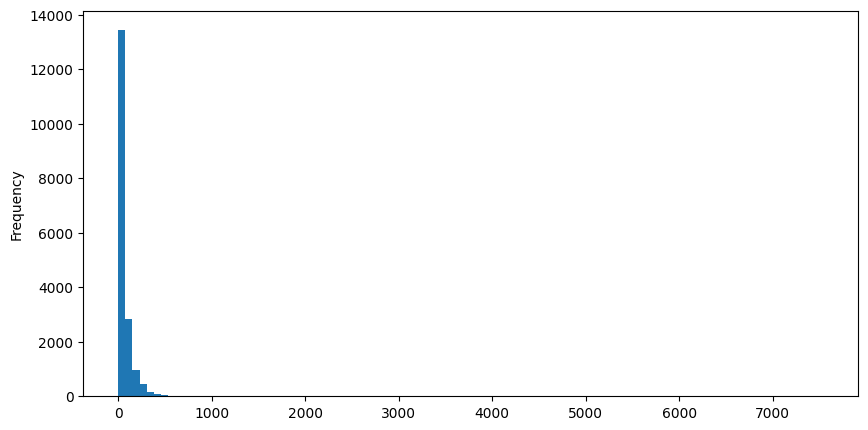

In [17]:
products.price.plot(kind="hist", bins=100, figsize=(10, 5));

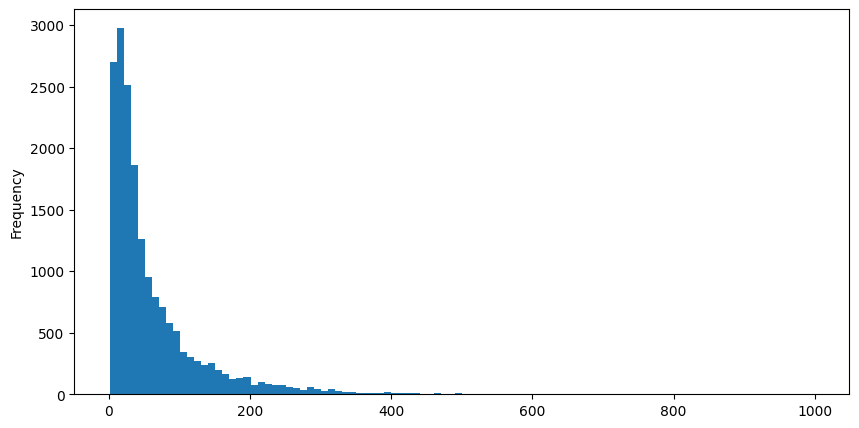

In [18]:
products[products.price < 1000].price.plot(kind="hist", bins=100, figsize=(10, 5));

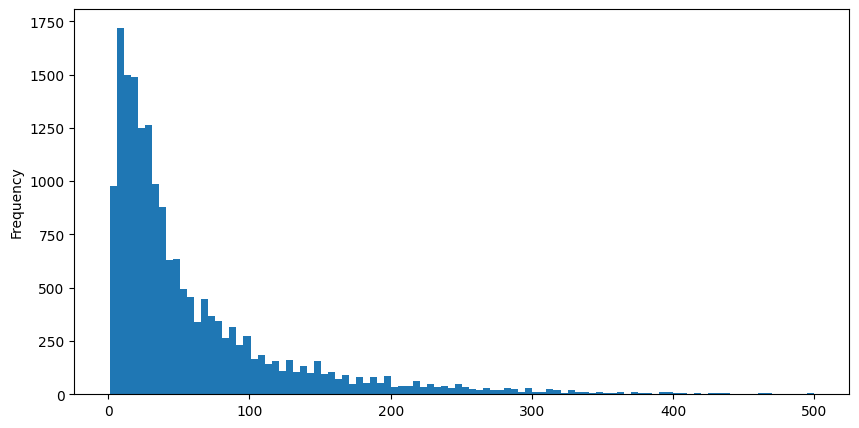

In [19]:
products[products.price < 500].price.plot(kind="hist", bins=100, figsize=(10, 5));

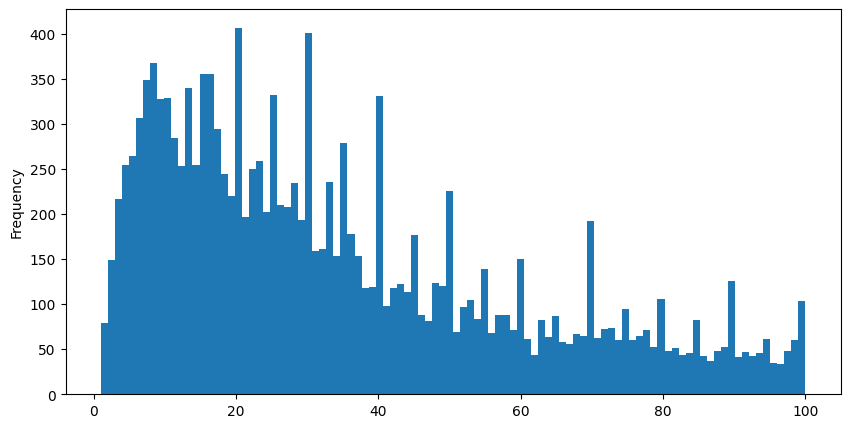

In [20]:
products[products.price < 100].price.plot(kind="hist", bins=100, figsize=(10, 5));

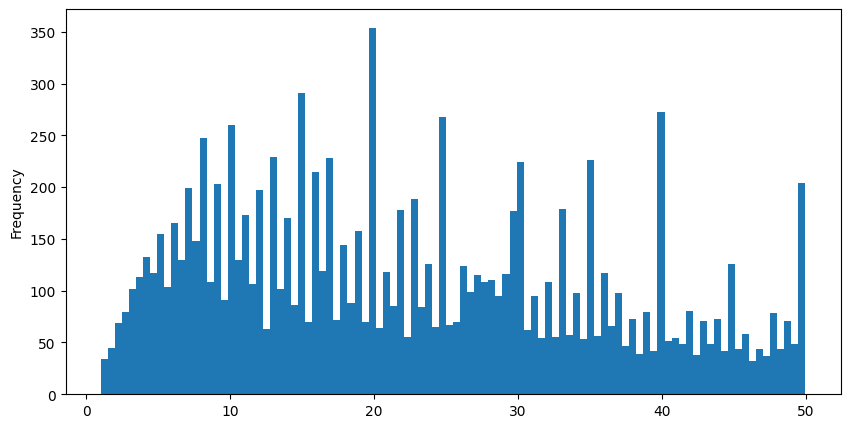

In [21]:
products[products.price < 50].price.plot(kind="hist", bins=100, figsize=(10, 5));

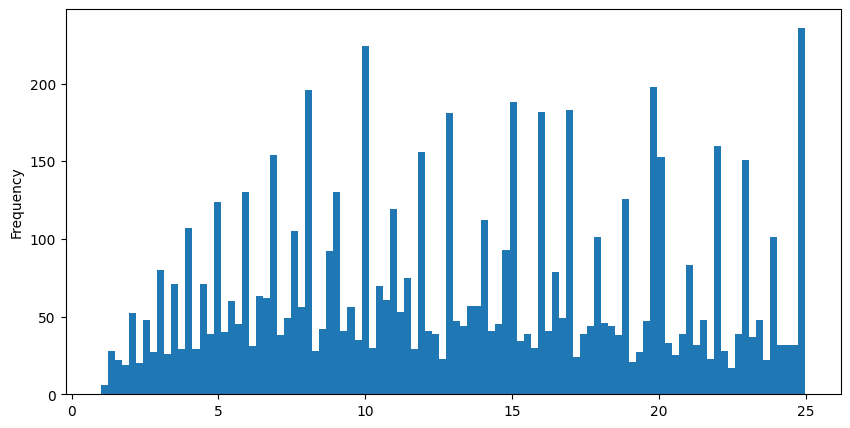

In [22]:
products[products.price < 25].price.plot(kind="hist", bins=100, figsize=(10, 5));

In [23]:
print(f"Mean price: {products.price.mean()}")
print(f"Median price: {products.price.median()}")
print(f"Max price: {products.price.max()}")
print(f"Min price: {products.price.min()}")

Mean price: 71.24545655294246
Median price: 35.04
Max price: 7537.21
Min price: 1.0


In [24]:
products.head()

,product_id,product_name,category,subcategory,price
19,55,A CURITYBINA 5ML UNIAO QUIMIC,MEDICAMENTOS,SIMILAR,14.09
20,56,A SAUDE DA MULHER 150ML EMS,MEDICAMENTOS,SIMILAR,19.55
21,68,ACTIFEDRIN 20CP FQM,MEDICAMENTOS,REFERENCIA ONEROSOS,15.03
22,69,ACTIFEDRIN XPE 100ML,MEDICAMENTOS,REFERENCIA ONEROSOS,15.85
23,76,ADEFORTE 3ML AMP GRO,MEDICAMENTOS,REFERENCIA SUPER ONEROSOS,25.37


In [25]:
products.to_parquet("../data/cleaned/products.parquet", index=False)